# Oracle CPU analysis

Datafile: a csv file exporting the data of the Kibana visualization **tomeu_racprod_cpu_free_beforeapplying_x100_div24** Export as Formatted!


## Read the datafile, make some cleaning and transformation.


In [20]:
# -*- coding: utf-8 -*-
import pandas as pd

df = pd.read_csv(#'./data/racprod_cpu_2020_December.csv', 
                 './data/all_cpu.csv',
                 index_col='timestamp_per_hour',
                 parse_dates=['timestamp_per_hour'],
                 date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M')
                )

df['idle_cpu_pct'] = df.avg_cpu_idle_pct*100/24
df['used_cpu_pct'] = 100 - df.idle_cpu_pct


In [21]:
df.sort_index(inplace=True)
#df.sort_index(ascending=False)
df.head()

,host_name,avg_cpu_idle_pct,idle_cpu_pct,used_cpu_pct
timestamp_per_hour,,,,
2020-10-01 00:00:00,srvmtszrh040.mts.pri,11.851,49.379167,50.620833
2020-10-01 00:00:00,srvmtszrh042.mts.pri,10.864,45.266667,54.733333
2020-10-01 01:00:00,srvmtszrh040.mts.pri,14.418,60.075000,39.925000
2020-10-01 01:00:00,srvmtszrh042.mts.pri,9.578,39.908333,60.091667
2020-10-01 02:00:00,srvmtszrh040.mts.pri,14.496,60.400000,39.600000


In [22]:
# We drop the columns that we won't need for the analysis.
df.drop(columns=['avg_cpu_idle_pct','idle_cpu_pct'],inplace=True)
df.head()

,host_name,used_cpu_pct
timestamp_per_hour,,
2020-10-01 00:00:00,srvmtszrh040.mts.pri,50.620833
2020-10-01 00:00:00,srvmtszrh042.mts.pri,54.733333
2020-10-01 01:00:00,srvmtszrh040.mts.pri,39.925000
2020-10-01 01:00:00,srvmtszrh042.mts.pri,60.091667
2020-10-01 02:00:00,srvmtszrh040.mts.pri,39.600000


## Period of time analyzed:

In [23]:
print( 'From:', df.index.min() )
print( '  To:', df.index.max() )


From: 2020-10-01 00:00:00
  To: 2020-12-16 23:00:00


# Analysis of the used CPU of each database server.

In [24]:
df_pivot = pd.pivot_table(df, index='timestamp_per_hour', values='used_cpu_pct', columns=['host_name'], aggfunc='sum')
df_pivot.head()

host_name,srvmtszrh040.mts.pri,srvmtszrh042.mts.pri
timestamp_per_hour,,
2020-10-01 00:00:00,50.620833,54.733333
2020-10-01 01:00:00,39.925000,60.091667
2020-10-01 02:00:00,39.600000,56.362500
2020-10-01 03:00:00,60.866667,51.945833
2020-10-01 04:00:00,42.379167,42.629167


## 1. Used CPU for each server.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2022d9e8>,
      dtype=object)

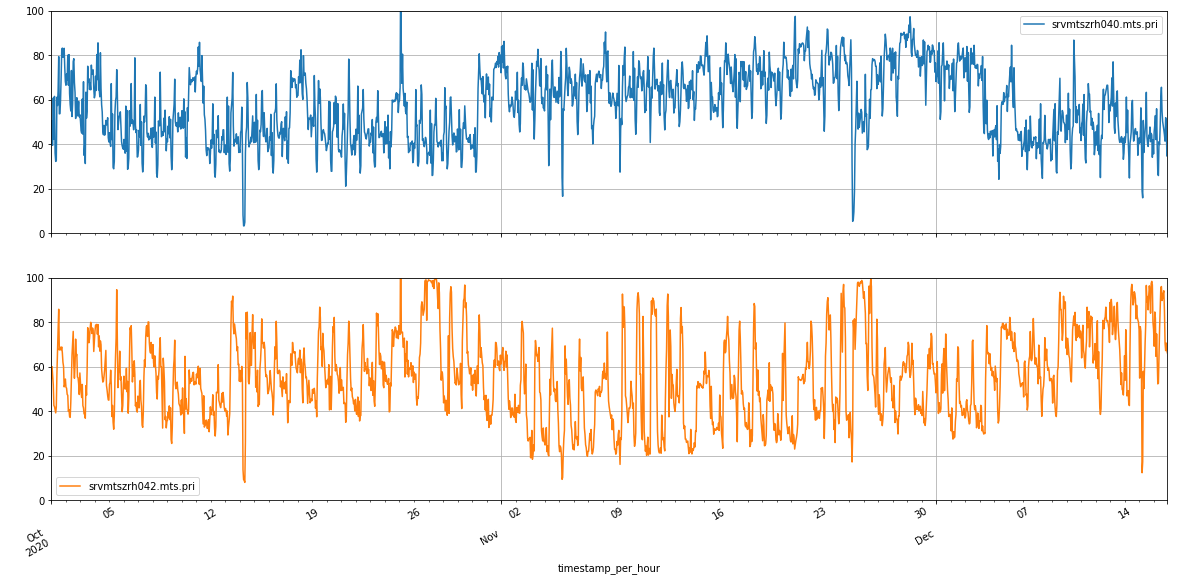

In [25]:
df_pivot.plot(kind='line', grid=True, ylim=(0,100), subplots=True, figsize=(20,10) )

***Use of CPU of each server in the same plot.***

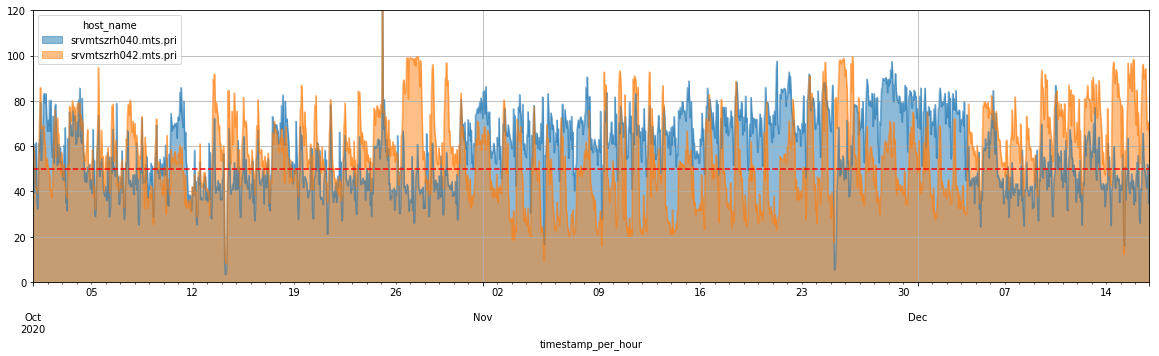

In [26]:
plot = df_pivot.plot.area(ylim=(0,120),figsize=(20,5), grid=True, stacked=False)
plot.axhline(y=50, color='red', linestyle='--')

## 2. What if one server is down?

The following plot is a stacked line plot that displays the ***CPU consumption of the sum of the 2 servers**.

All periods having a sum of more than 100%, are the periods that a single server would not be able to cope with the whole workload, meaning that the performance would be so low that most of the business platforms, users, clients, etc., could have the feeling that the systems are down.

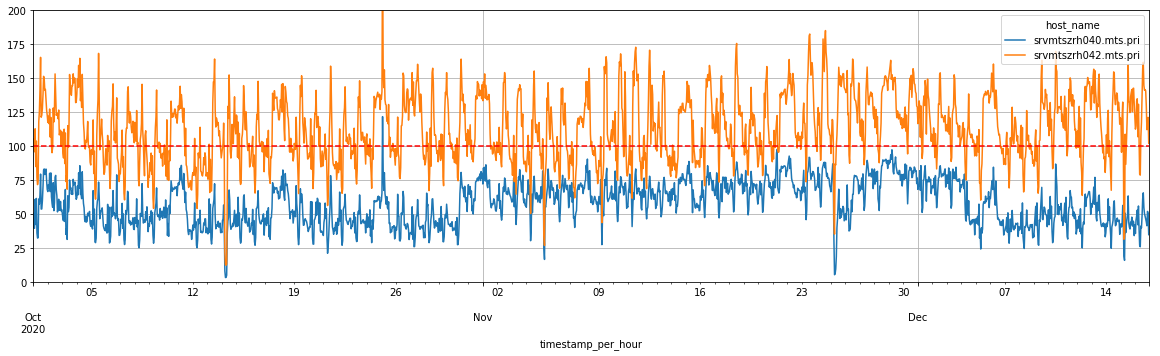

In [27]:
plot = df_pivot.plot(kind='line', grid=True, ylim=(0,200), figsize=(20,5), stacked=True)
plot.axhline(y=100, color='red', linestyle='--')

### What is the pattern of the CPU load during working hours and weehdays?

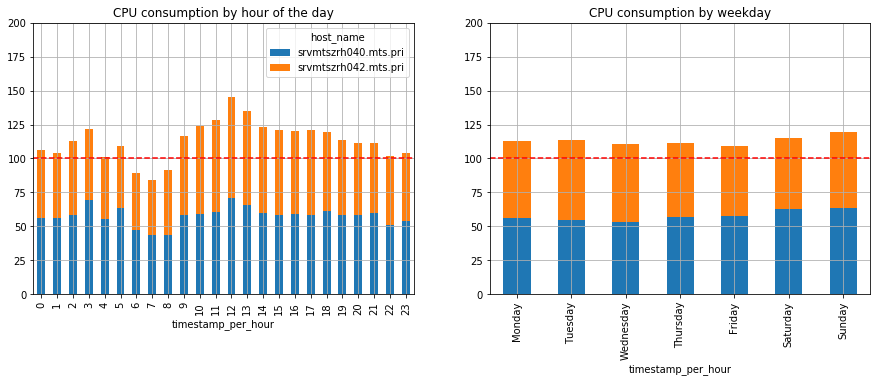

In [28]:
import matplotlib.pyplot as plt

df_pivot.head()
#df_pivot.resample(rule='H').mean()

fig, axes = plt.subplots(nrows=1,ncols=2)

# CPU consumption by hour of the day
df_hourly = df_pivot.groupby(df_pivot.index.hour).mean()
h = df_hourly.plot(ax = axes[0],kind='bar', grid=True, ylim=(0,200), stacked=True, title='CPU consumption by hour of the day')
h.axhline(y=100, color='red', linestyle='--')

# CPU consumption by weekday
df_weekday = df_pivot.groupby(df_pivot.index.weekday_name).mean()

# The following shit, until plotting, is for ordering the weekdays!!!
# http://blog.quizzicol.com/2016/10/03/sorting-dates-in-python-by-day-of-week/
sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sorterIndex = dict(zip(sorter,range(len(sorter))))
df_weekday['Day_id'] = df_weekday.index
df_weekday['Day_id'] = df_weekday['Day_id'].map(sorterIndex)
df_weekday.sort_values('Day_id', inplace=True)
df_weekday.drop(['Day_id'], axis=1, inplace=True)

wd = df_weekday.plot(ax = axes[1], kind='bar', grid=True, ylim=(0,200), legend=False, figsize=(15,5), stacked=True, title='CPU consumption by weekday')
wd.axhline(y=100, color='red', linestyle='--')

#df_weekday

## 3. Statistical analysis of the data samples 

Quick overview of data statistics: number of samples, mean, desviation, ...

In [29]:
df_pivot.describe()

host_name,srvmtszrh040.mts.pri,srvmtszrh042.mts.pri
count,1848.000000,1848.000000
mean,57.830968,55.302812
std,15.986350,18.618344
min,3.366667,8.120833
25%,44.810417,41.472917
50%,58.087500,54.216667
75%,70.271875,67.921875
max,121.754167,129.908333


In [30]:
df_pivot.median()

host_name
srvmtszrh040.mts.pri    58.087500
srvmtszrh042.mts.pri    54.216667
dtype: float64

**How is the data distributed?**

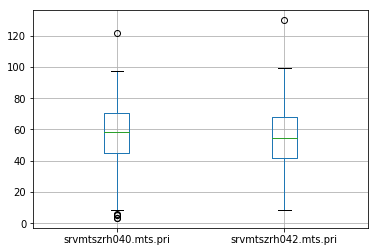

In [31]:
df_pivot.boxplot()

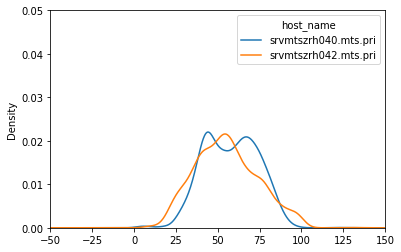

In [32]:
df_pivot.plot.density(xlim=(-50,150),ylim=(0,0.05))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a201e8908>,
      dtype=object)

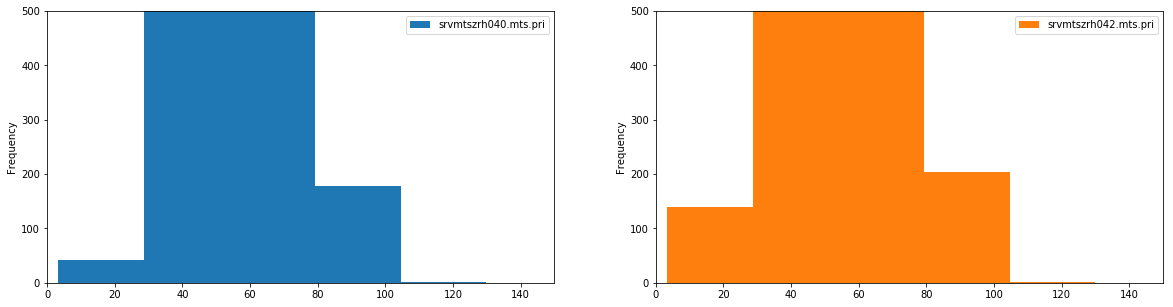

In [33]:
df_pivot.plot.hist(bins=5, subplots=True, layout=(1,2), figsize=(20,5), xlim=(0,150), ylim=(0,500))

## 4. Non-HA index (KPIs)

In [34]:
df_kpi = df_pivot.copy()
df_kpi['total_cpu_pct'] = df_kpi['srvmtszrh040.mts.pri'] + df_kpi['srvmtszrh042.mts.pri']
df_kpi.drop(columns=['srvmtszrh040.mts.pri','srvmtszrh042.mts.pri'],inplace=True)
df_kpi.head()

host_name,total_cpu_pct
timestamp_per_hour,
2020-10-01 00:00:00,105.354167
2020-10-01 01:00:00,100.016667
2020-10-01 02:00:00,95.962500
2020-10-01 03:00:00,112.812500
2020-10-01 04:00:00,85.008333


In [35]:
s_hours = df_kpi.copy()
s_hours = s_hours.groupby(s_hours.index.month).count()
s_hours.index.names = ['month']
s_hours = s_hours.rename(columns={"total_cpu_pct": "hours"})
s_hours = s_hours['hours']
s_hours

month
10    744
11    720
12    384
Name: hours, dtype: int64

host_name,NHA,NHApct
month,,
10,442,0.594086
11,504,0.700000
12,299,0.778646


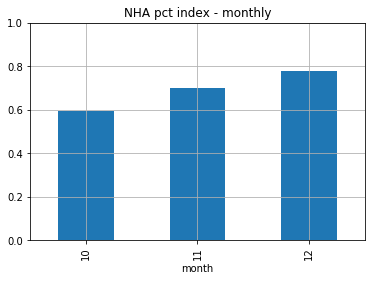

In [36]:
df_kpi_monthly = df_kpi.query('total_cpu_pct >= 100')
df_kpi_monthly = df_kpi_monthly.groupby(df_kpi_monthly.index.month).count()
df_kpi_monthly.index.names = ['month']
df_kpi_monthly = df_kpi_monthly.rename( columns={'total_cpu_pct':'NHA'})
df_kpi_monthly['NHApct'] = df_kpi_monthly['NHA'] / s_hours  # each month has diff. num. of hurs depending on the number of days
#df_kpi_monthly.head()
df_kpi_monthly['NHApct'].plot(kind='bar', grid=True, ylim=(0,1), legend=False, title='NHA pct index - monthly')
df_kpi_monthly

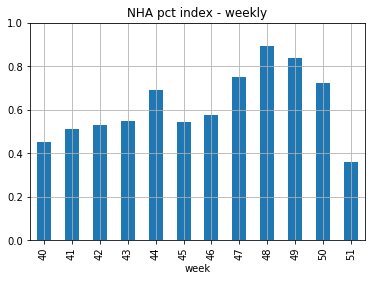

In [37]:
df_kpi_weekly = df_kpi.query('total_cpu_pct >= 100')
df_kpi_weekly = df_kpi_weekly.groupby(df_kpi_weekly.index.week).count()
df_kpi_weekly.index.names = ['week']
df_kpi_weekly = df_kpi_weekly.rename( columns={'total_cpu_pct':'NHA'})
df_kpi_weekly['NHApct'] = df_kpi_weekly['NHA'] / 168 # 1 week = 168 hours
df_kpi_weekly['NHApct'].plot(kind='bar', grid=True, ylim=(0,1), legend=False, title='NHA pct index - weekly')

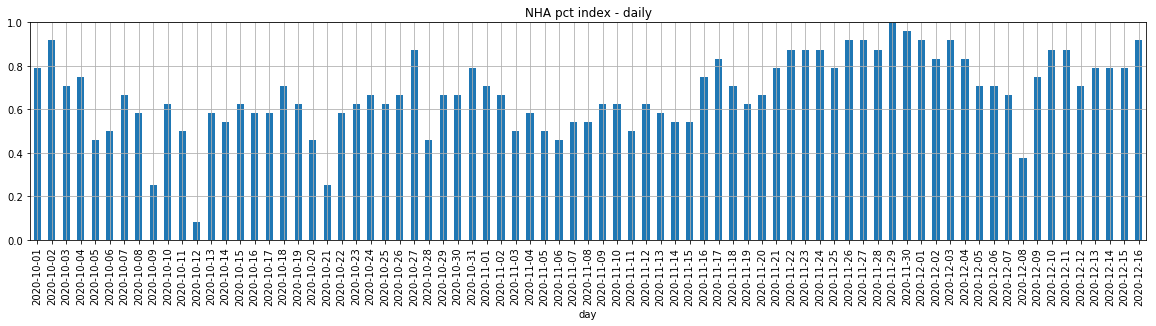

In [39]:
df_kpi_daily = df_kpi.query('total_cpu_pct >= 100')
df_kpi_daily = df_kpi_daily.groupby(df_kpi_daily.index.strftime('%Y-%m-%d')).count()
df_kpi_daily.index.names = ['day']
df_kpi_daily = df_kpi_daily.rename( columns={'total_cpu_pct':'NHA'})
df_kpi_daily['NHApct'] = df_kpi_daily['NHA'] / 24 # 1 day = 24 hours
df_kpi_daily['NHApct'].plot(kind='bar', grid=True, ylim=(0,1), figsize=(20,4), legend=False, title='NHA pct index - daily')